# Import 

In [7]:
import os
import random
import datetime
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import (Conv2D, Conv2DTranspose, Dense, Flatten, 
                                    Dropout, BatchNormalization, Reshape, LeakyReLU, LSTM)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.datasets import cifar100
from tensorflow.keras import backend as K

In [8]:
import shutil
def remove_all_file(filepath):
    if os.path.exists(filepath):
        shutil.rmtree(filepath, ignore_errors=True)
        os.makedirs(filepath)
    else:
        os.makedirs(filepath)

# Data

In [9]:
# 추후 kb api 통해 데이터 전처리

from keras.preprocessing.image import ImageDataGenerator

import_train_datagen = ImageDataGenerator(rescale = 1./255)  # 이미지 데이터 전처리


                                   



import_training_set_oneDayChart = import_train_datagen.flow_from_directory("stock_data/image_train/outputSubdivision/oneDayChart",
                                                shuffle= True,
                                                seed = 17,
                                                batch_size = 226088,
                                                 target_size=(28,44),
                                                 class_mode = 'input')
                
                                   


import_test_set_oneDayChart = import_train_datagen.flow_from_directory("stock_data/image_test/outputSubdivision/oneDayChart",
                                                shuffle= True,
                                                seed = 7,
                                                batch_size = 53859,
                                                 target_size=(28, 44),
                                                 class_mode = 'input')




FileNotFoundError: [Errno 2] No such file or directory: 'stock_data/image_train/outputSubdivision/oneDayChart'

In [4]:
trainX_oneDayChart = import_training_set_oneDayChart[0][0]
#trainy_day = import_training_set_day[0][1]

print(1)



testX_oneDayChart = import_test_set_oneDayChart[0][0]
#testy_day = import_test_set_day[0][1] 

print(1)


train_data_oneDayChart = np.reshape(trainX_oneDayChart, (trainX_oneDayChart.shape))
test_data_oneDayChart = np.reshape(testX_oneDayChart, (testX_oneDayChart.shape))

print(1)





1
1
1


# Model

In [17]:
import tensorflow  as tf

with tf.device('/CPU:0'):
#     input_shape = (train_data_oneDayChart.shape)
    batch_size = 32
    kernel_size = 3
    latent_dim = 256
    layer_filters = [64, 128, 256]

    encoder_input = Input(shape=(28,44,3))

    # 28 X 28
    x = Conv2D(64, 3, padding='same')(encoder_input) 
    x = BatchNormalization()(x)
    x = LeakyReLU()(x) 

    # 28 X 28 -> 14 X 14
    x = Conv2D(128, 3, strides=2, padding='same')(x)
    x = BatchNormalization()(x) 
    x = LeakyReLU()(x) 

    # 14 X 14 -> 7 X 7
    x = Conv2D(256, 3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    # 17 X 7
    x = Conv2D(512, 3,strides=2,  padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)

    # 2D 좌표로 표기하기 위하여 2를 출력값으로 지정합니다.
    encoder_output = Dense(4)(x)



    # Input으로는 2D 좌표가 들어갑니다.
    decoder_input = Input(shape=(4, ))


    x = Dense(7*11*512)(decoder_input)
    x = Reshape( (7,11, 512))(x)

    # 7 X 7 -> 7 X 7
    x = Conv2DTranspose(512, 3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    # 7 X 7 -> 14 X 14
    x = Conv2DTranspose(256, 3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    # 14 X 14 -> 28 X 28
    x = Conv2DTranspose(128, 3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    # 28 X 28 -> 28 X 28
    x = Conv2DTranspose(64, 3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    # 최종 output
    decoder_output = Conv2DTranspose(3, 3, strides=1, padding='same', activation='tanh')(x)

    encoder_day = Model(encoder_input, encoder_output)
    decoder_day = Model(decoder_input, decoder_output)






    encoder_in = Input(shape=(28, 44, 3))
    LEARNING_RATE = 0.0005
    BATCH_SIZE = 32
    x = encoder_day(encoder_in)
    decoder_out = decoder_day(x)


    auto_encoder_day = Model(encoder_in, decoder_out)
    encoder_day.summary()
    decoder_day.summary()
    auto_encoder_day.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE), loss=tf.keras.losses.MeanSquaredError())

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 28, 44, 3)]       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 28, 44, 64)        1792      
                                                                 
 batch_normalization_56 (Bat  (None, 28, 44, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_56 (LeakyReLU)  (None, 28, 44, 64)        0         
                                                                 
 conv2d_29 (Conv2D)          (None, 14, 22, 128)       73856     
                                                                 
 batch_normalization_57 (Bat  (None, 14, 22, 128)      512       
 chNormalization)                                         

In [24]:
checkpoint_path = 'models/small_autoencoder_check_point.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_best_only=True, 
                             save_weights_only=True, 
                             monitor='loss', 
                             verbose=1)

In [25]:
# NVDIA GPU 작동 설정 - 메모리 할당 관련 코드
#NVIDIA GPU가 있지 않다면 코드 절대 실행 X

gpus = tf.config.experimental.list_physical_devices('GPU') 

if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


In [26]:
with tf.device('/CPU:0'):
    auto_encoder_day.fit(train_data_oneDayChart, train_data_oneDayChart, epochs=55, batch_size=64, callbacks=[checkpoint], validation_data=(test_data_oneDayChart, test_data_oneDayChart))

Epoch 1/55
3533/3533 [==============================] - 669s 189ms/step - loss: 0.0060 - val_loss: 3.8251e-04

Epoch 00001: loss improved from inf to 0.00598, saving model to models\small_autoencoder_check_point.ckpt
Epoch 2/55
3533/3533 [==============================] - 704s 199ms/step - loss: 2.1312e-04 - val_loss: 1.3591e-04

Epoch 00002: loss improved from 0.00598 to 0.00021, saving model to models\small_autoencoder_check_point.ckpt
Epoch 3/55
3533/3533 [==============================] - 707s 200ms/step - loss: 1.3657e-04 - val_loss: 1.5089e-04

Epoch 00003: loss improved from 0.00021 to 0.00014, saving model to models\small_autoencoder_check_point.ckpt
Epoch 4/55
3533/3533 [==============================] - 736s 208ms/step - loss: 1.0477e-04 - val_loss: 8.5706e-05

Epoch 00004: loss improved from 0.00014 to 0.00010, saving model to models\small_autoencoder_check_point.ckpt
Epoch 5/55
3533/3533 [==============================] - 728s 206ms/step - loss: 7.7931e-05 - val_loss: 6.261

3533/3533 [==============================] - 714s 202ms/step - loss: 1.0972e-05 - val_loss: 9.0697e-06

Epoch 00041: loss did not improve from 0.00001
Epoch 42/55
3533/3533 [==============================] - 718s 203ms/step - loss: 1.0450e-05 - val_loss: 9.0018e-06

Epoch 00042: loss improved from 0.00001 to 0.00001, saving model to models\small_autoencoder_check_point.ckpt
Epoch 43/55
3533/3533 [==============================] - 721s 204ms/step - loss: 1.0255e-05 - val_loss: 2.6829e-05

Epoch 00043: loss improved from 0.00001 to 0.00001, saving model to models\small_autoencoder_check_point.ckpt
Epoch 44/55
3533/3533 [==============================] - 716s 203ms/step - loss: 1.0038e-05 - val_loss: 9.9061e-06

Epoch 00044: loss improved from 0.00001 to 0.00001, saving model to models\small_autoencoder_check_point.ckpt
Epoch 45/55
3533/3533 [==============================] - 713s 202ms/step - loss: 1.2075e-05 - val_loss: 8.6925e-06

Epoch 00045: loss did not improve from 0.00001
Epoch 46

In [28]:
en_train_data_day = auto_encoder_day.predict(train_data_oneDayChart)
en_test_data_day =  auto_encoder_day.predict(test_data_oneDayChart)

print(1)

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[32,64,28,44] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_14/model_13/conv2d_transpose_22/conv2d_transpose (defined at \AppData\Local\Temp/ipykernel_10368/1231674141.py:1) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[model_14/model_13/conv2d_transpose_24/Tanh/_113]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) Resource exhausted:  OOM when allocating tensor with shape[32,64,28,44] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_14/model_13/conv2d_transpose_22/conv2d_transpose (defined at \AppData\Local\Temp/ipykernel_10368/1231674141.py:1) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_predict_function_271142]

Function call stack:
predict_function -> predict_function


In [29]:
from keras.models import load_model
auto_encoder_day.save('models/auto_encoder_output_oneDayChart_28_44_4.h5')
encoder_day.save('models/encoder_output_oneDayChart_28_44_4.h5')
decoder_day.save('models/decoder/decoder_output_oneDayChart_28_44_4.h5')

In [197]:
def make_data_for_dnn(day,week,month,next_day):

    encoder_day =  load_model('models/encoder/small_encoder_28_44_4.h5')
    encoder_week =  load_model('models/decoder/small_decoder_28_44_4.h5')
    encoder_month =  load_model('models/decoder/small_decoder_28_44_4.h5')
    
    day_val = encoder_day.predict(day)
    week_val = encoder_week.predict(week)
    month_val = encoder_month.predict(month)
    
    next_day = encoder_day.predict(next_day)
    
    return list(day_val+ week_val+ month_val)


In [223]:
encoder_input_day = Input(shape=(1,10))
x_day = keras.layers.Dense(10, activation='relu')(encoder_input_day)
x_day = keras.layers.Dense(6, activation='relu')(x_day)
x_month = Dense(4, activation='relu')(x_day)
x_month = Dense(4)(x_day)

model_dnn = Model(inputs= encoder_input_day,outputs = x_month)


history = model_dnn.fit(df[:,0:4],df[:,-1],steps_per_epoch = 10 ,epochs = 700,validation_data = (df_test[:,0:4],df_test[:,-1]),validation_steps =15)


NameError: name 'df' is not defined

In [222]:
# 5번과 7번 분류 65% 추세 넣어서 
# 5번과 7번 분류 70% 추세 안넣어서 import_train 으로 
import keras
from keras.layers import Concatenate

encoder_input_day = Input(shape=(1,4))
encoder_input_week = Input(shape=(1,3))
encoder_input_month = Input(shape=(1,3))



x_day = keras.layers.Dense(10, activation='relu')(encoder_input_day)
x_week = keras.layers.Dense(10, activation='relu')(encoder_input_week)
x_month = Dense(14, activation='relu')(encoder_input_month)


inu = Concatenate([x_day,x_week,x_month])


x = tf.keras.layers.Dense(1, activation='relu')(inu)
output = tf.keras.layers.Dense(4)(x)

# model_dnn.compile(optimizer='adam',
#               loss='mse',
#              )


# model_dnn = Model(inputs=[encoder_input_day,encoder_input_week,encoder_input_month],outputs = output)

# history = model_dnn.fit(np.array(p),np.array(xy[:,1]),steps_per_epoch = 10 ,epochs = 700,validation_data = (np.array(p_k),np.array(vr[:,1])),validation_steps =15)



TypeError: Inputs to a layer should be tensors. Got: <keras.layers.merge.Concatenate object at 0x7f7e25c21130>

# Result

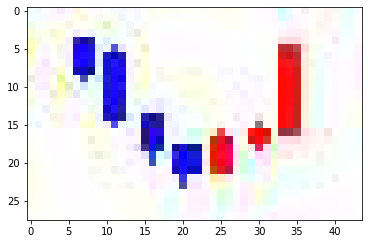

In [183]:
plt.imshow(np.array(testX[3]))




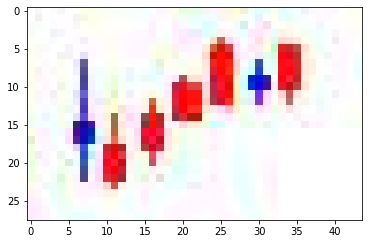

In [184]:
plt.imshow(np.array(test_data[3]))


[[ -459.4101    -1014.7185      683.8709       12.1562805]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


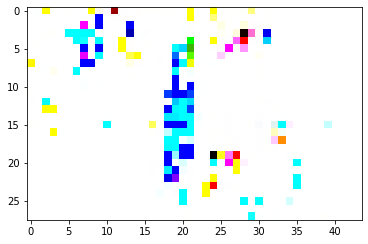

In [28]:
import PIL.Image as pilimg
import numpy as np
from keras.models import load_model
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt

def convertImgToArray(path):
    im = np.array(pilimg.open("{}".format(path)))
    im = im.reshape(1,28, 44, 3)
    return [im]




t = encoder.predict(convertImgToArray('stock_data/image_train/dayChart/dayChart1/000020_20210608.jpg')) 
p = p[0]
plt.imshow(p)

p = decoder.predict(t) 
p = p[0]
plt.imshow(p)

In [27]:
encoder = load_model('models/encoder_day_28_44_4.h5')
autoencoder = load_model('models/auto_encoder_day_28_44_4.h5')
decoder = load_model('models/decoder_day_28_44_4.h5')